## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import os

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('/Users/y0g03pj/Documents/Ticket/complaints-2021-05-14_08_16.json') # Write the path to your data file and load it 

# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [3]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
display(df.head())
display(df.info())
display(df.describe(include='all'))

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

None

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
count,78313,78313,78313,78313.0,10900,71556,78313,78313,78313,76322,...,78313,78313,78313,78313,4,67742,78313,78313,32016,77305
unique,1,1,78313,NaN,3,9442,78313,154,3444,62,...,8,1,6,3309,3,72,2,20931,205,5
top,complaint-public-v2,complaint,3211475,NaN,Older American,606XX,3211475,"Loan modification,collection,foreclosure",2015-08-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2012-06-21T12:00:00-05:00,Company has responded to the consumer and the ...,Checking account,Yes,,Credit card company isn't resolving a dispute ...,N/A
freq,78313,78313,1,NaN,6103,472,1,9743,82,14009,...,60230,78313,47972,105,2,17182,78217,57241,2904,42847
mean,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign new column names
df.columns = df.columns.str.lstrip('_')
df.columns = df.columns.str.replace('source.', '')
df.columns

/var/folders/jw/d4zv27ws3sn9hb1g62hk8nnr0000gq/T/ipykernel_41600/748074646.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.



Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
# Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened'] ==''] = np.nan

In [8]:
# df shape before dropna
print('df.shape before dropna =',df.shape)
#Remove all rows where complaints column is nan
df.dropna(subset='complaint_what_happened', inplace=True)
# df shape after dropna
print('df.shape after dropna =',df.shape)

df.shape before dropna = (78313, 22)
df.shape after dropna = (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


#### Convert data types

In [9]:
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   index                      21072 non-null  string
 1   type                       21072 non-null  string
 2   id                         21072 non-null  string
 3   score                      21072 non-null  Int64 
 4   tags                       3816 non-null   string
 5   zip_code                   16427 non-null  string
 6   complaint_id               21072 non-null  string
 7   issue                      21072 non-null  string
 8   date_received              21072 non-null  string
 9   state                      20929 non-null  string
 10  consumer_disputed          21072 non-null  string
 11  product                    21072 non-null  string
 12  company_response           21072 non-null  string
 13  company                    21072 non-null  string
 14  submit

#### Make the text lowercase

In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.
df['clean_complaints'] = df['complaint_what_happened'].str.lower()

#### Create function to extract regex

In [11]:
def extract_regex(df, new_df, regexes):
    if not isinstance(regexes, list):
        regexes = [regexes]
    new_df = pd.DataFrame()
    for reg in regexes:
        if new_df.empty:
            new_df = pd.DataFrame(df[df['clean_complaints'].str.contains(reg, regex=True)]['clean_complaints'])            
        else:
            new_df = pd.concat([new_df, pd.DataFrame(df[df['clean_complaints'].str.contains(reg, regex=True)]['clean_complaints'])])
        
    # Apply the regular expressions to the DataFrame
    new_df['extracted'] = new_df['clean_complaints'].apply(lambda x: [match for regex in regexes for match in re.findall(regex, x)])
    # Display the 'extracted' column
    return pd.DataFrame((new_df['extracted']))

#### Remove text in square brackets

In [12]:
df_square_brackets = pd.DataFrame()
regex = r'(\[.*?\])'
extract_regex(df, df_square_brackets, regex)

/var/folders/jw/d4zv27ws3sn9hb1g62hk8nnr0000gq/T/ipykernel_41600/304458484.py:7: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,extracted
316,"[[ t ], [ fico scores, xxxx, xxxx and xxxx, re..."
386,[[ any information they gave you about the deb...
984,[[ to xxxx ]]
1212,"[[ a ], [ 1 ]]"
1567,[[ s ]]
...,...
75418,[[ u.s. consumer financial protection ]]
75503,"[[ my ], [ they ]]"
76165,"[[ cell ], [ home ]]"
76692,[[ i was ]]


In [13]:
df['clean_complaints'] = df['clean_complaints'].str.replace(regex, '', regex = True)

In [14]:
extract_regex(df, df_square_brackets, regex)

/var/folders/jw/d4zv27ws3sn9hb1g62hk8nnr0000gq/T/ipykernel_41600/304458484.py:7: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,extracted


#### Remove punctuation

In [15]:
df_punctuation = pd.DataFrame()
regex = f'[{string.punctuation}]'
extract_regex(df, df_punctuation, regex)

,extracted
1,"[., ., ., ., ., #, .]"
2,"[/, /, ., ., /, /, /, /, !, .]"
10,"[/, /, ., ,, ., .]"
11,"[/, /, ,, ,, {, $, ., }, ., ,, ., ., ., ,, ., ..."
14,"[{, $, ., }, /, /]"
...,...
78303,"[,, -, ., (, ), ., ,, ., (, ), ., ,, ,, ,, {, ..."
78309,"[,, /, /, ,, ,, ., /, /, ,, ., ., ., ,, ,, ., ..."
78310,"[., ., ., ., ., ., ,, ., !, ,, ., ., ., ., ., ..."
78311,"[., ', ,, "", ', ', ., ', ,, ., {, $, ., }, (, ..."


In [16]:
# Remove punctuation from 'clean_complaints'
df['clean_complaints'] = df['clean_complaints'].str.replace(regex, '', regex=True)

In [17]:
extract_regex(df, df_punctuation, regex)

,extracted


#### Remove words containing numbers

Filter words containing numbers anywhere

In [18]:
# Create a new DataFrame that contains rows that have square brackets and its text
df_word_num = pd.DataFrame()

# Define the regular expressions
regex = [r'\b[A-Za-z]+\d+\w*\b', r'\b\d+[A-Za-z]+\w*\b']

extract_regex(df, df_word_num, regex).head(30)

,extracted
2,[xxxx2018]
10,[xxxx2019]
11,"[xxxx2018, xxxx2018, xxxx2018, 10minutes, 10mins]"
14,[xxxx2018]
17,"[xxxx2019, xxxx2019, xxxx2019]"
20,[xxxx2019]
21,"[xxxx2019, xxxx2019]"
26,[xxxx2019]
32,[xxxx2019]
35,"[xxxx2019, xxxx2019]"


Filter words containing numbers in between

In [19]:
# Create a new DataFrame that contains rows that have square brackets and its text
df_word_num = pd.DataFrame()

# Define the regular expressions
regex = r'\b[A-Za-z]+\d+[A-Za-z]+\b'

extract_regex(df, df_word_num, regex).head(10)

,extracted
83,[xxxx2019name]
142,[chasemortgagehasautomaticallydeducted2mortgag...
155,[xxxx19or]
316,[chapter4definitions]
336,[xxxx2019i]
921,[f2f]
1096,[fha2lp]
1617,[re3cently]
1638,[xxxx2000and]
1765,[xxxx2012i]


Remove words containing numbers in between

In [20]:
# Remove punctuation from 'clean_complaints'
df['clean_complaints'] = df['clean_complaints'].str.replace(regex, '', regex=True)

In [21]:
extract_regex(df, df_word_num, regex).head(10)

,extracted


#### Clean space

In [22]:
print(df['clean_complaints'][1])

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services 
in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt 
i have a right to know this information as a consumer 

chase account  xxxx xxxx xxxx xxxx thanks in advance for your help


In [23]:
# Removing leading/trailing whitespace and empty sentences
df['clean_complaints'] = df['clean_complaints'].apply(lambda x: '\n'.join(sent.strip() for sent in x.split('\n') if sent.strip() != ''))

In [24]:
print(df['clean_complaints'][1])

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services
in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt
i have a right to know this information as a consumer
chase account  xxxx xxxx xxxx xxxx thanks in advance for your help


In [25]:
# Removing extra spaces between words.
df['clean_complaints'] = df['clean_complaints'].apply(lambda x: '\n'.join(' '.join(word.strip() for word in sent.split() if word.strip()!= '') for sent in x.split('\n') if sent.strip()!= ''))

In [26]:
print(df['clean_complaints'][1])

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services
in 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt
i have a right to know this information as a consumer
chase account xxxx xxxx xxxx xxxx thanks in advance for your help


#### Drop empty rows

In [27]:
# df shape before dropna
print('df.shape before dropna =',df.shape)
#Remove all rows where complaints column is nan
df.dropna(subset='clean_complaints', inplace=True)
# Drop rows where column 'clean_complaints' is equal to ''
df = df[df['clean_complaints'] != '']
# df shape after dropna
print('df.shape after dropna =',df.shape)
# reset index
df.reset_index(drop=True, inplace=True)

df.shape before dropna = (21072, 23)
df.shape after dropna = (21071, 23)


#### Drop duplicates

In [28]:
# df shape before drop_duplicates
print('df.shape before drop_duplicates =',df.shape)
# Drop duplicate rows based on column 'clean_complaints'
df = df.drop_duplicates(subset='clean_complaints')
# df shape after drop_duplicates
print('df.shape after drop_duplicates =',df.shape)

df.shape before drop_duplicates = (21071, 23)
df.shape after drop_duplicates = (20897, 23)


In [29]:
if os.path.isfile('df.csv'):
  # load df_clean
  df = pd.read_csv('df.csv')
else:
    df.to_csv('df.csv', index=False)

#### Lemmatize the texts

In [30]:
#Write your function to Lemmatize the texts
def lemmatize(sent):        
    spacy.prefer_gpu()
    doc = nlp(sent)
    return ' '.join([token.lemma_ for token in doc])

In [31]:
if os.path.isfile('df_clean.csv'):
    #tag remote collab
    df = pd.read_csv('df.csv')
    # load df_clean
    df_clean = pd.read_csv('df_clean.csv')
else:
    #tag remote collab
    df = pd.read_csv('df.csv')

    #Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
    df_clean = pd.DataFrame()

    # initialize 'complaints' column
    df_clean['complaints'] = df['clean_complaints']

    # process 'complaints_lemmatized' column
    df_clean['complaints_lemmatized'] = pd.DataFrame(df_clean['complaints'].apply(lambda x: '\n'.join(lemmatize(sent) for sent in x.split('\n'))))

    # Store df_clean for later use
    df_clean.to_csv('df_clean.csv', index=False)

In [32]:
print(df_clean['complaints_lemmatized'][0])

good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service
in 2018 I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt
I have a right to know this information as a consumer
chase account xxxx xxxx xxxx xxxx thank in advance for your help


In [33]:
df_clean

,complaints,complaints_lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,I upgrade my xxxx xxxx card in xxxx2018 and be...
2,chase card was reported on xxxx2019 however fr...,chase card be report on xxxx2019 however fraud...
3,on xxxx2018 while trying to book a xxxx xxxx t...,on xxxx2018 while try to book a xxxx xxxx tick...
4,my grand son give me check for 160000 i deposi...,my grand son give I check for 160000 I deposit...
...,...,...
20892,after being a chase card customer for well ove...,after be a chase card customer for well over a...
20893,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
20894,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
20895,i have had flawless credit for 30 yrs ive had ...,I have have flawless credit for 30 yrs I ve ha...


In [34]:
def pos_tag(text):
    # write your code here
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
    return lemmatize(' '.join([word for word, tag in pos_tags if tag.startswith('NN')]))

In [35]:
#Write your function to extract the POS tags 

if os.path.isfile('df_clean_v1.csv'):
  #tag remote collab
  df = pd.read_csv('df.csv')
  # load df_clean
  df_clean = pd.read_csv('df_clean_v1.csv')
  # Replace NaN values with an empty string
  df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
else:
  #tag remote collab
  df = pd.read_csv('df.csv')
  #tag remote collab
  df_clean = pd.read_csv('df_clean.csv')

  nltk.download('punkt')
  # Make sure you have the necessary NLTK data downloaded
  nltk.download('averaged_perceptron_tagger')

  df_clean['complaint_POS_removed'] = pd.DataFrame(df_clean['complaints'].apply(lambda x: '\n'.join(pos_tag(sent) for sent in x.split('\n'))))
  # Replace NaN values with an empty string
  df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
  # Store df_clean for later use
  df_clean.to_csv('df_clean_v1.csv', index=False)

In [36]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,I upgrade my xxxx xxxx card in xxxx2018 and be...,I card xxxx2018 agent upgrade date agent infor...
2,chase card was reported on xxxx2019 however fr...,chase card be report on xxxx2019 however fraud...,card xxxx2019 application identity consent ser...
3,on xxxx2018 while trying to book a xxxx xxxx t...,on xxxx2018 while try to book a xxxx xxxx tick...,xxxx2018 book xxxx ticket I offer ticket rewar...
4,my grand son give me check for 160000 i deposi...,my grand son give I check for 160000 I deposit...,son deposit chase account fund chase bank acco...
...,...,...,...
20892,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
20893,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxxxxxx I cha xxxx visa credit card provider ...
20894,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,I pay risk consumers bank app I chase year mob...
20895,i have had flawless credit for 30 yrs ive had ...,I have have flawless credit for 30 yrs I ve ha...,I credit yrs credit card chase freedom xxxx pr...


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [37]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace(r'xxxx*','', regex =True)
# Replace NaN values with an empty string
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')

In [38]:
# Removing leading/trailing whitespace and empty sentences
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].apply(lambda x: '\n'.join(sent.strip() for sent in x.split('\n') if sent.strip() != ''))
# Removing extra spaces between words.
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].apply(lambda x: '\n'.join(' '.join(word.strip() for word in sent.split() if word.strip()!= '') for sent in x.split('\n') if sent.strip()!= ''))

In [39]:
#All masked texts has been removed
df_clean

,complaints,complaints_lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service\ndeb...
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,I upgrade my xxxx xxxx card in xxxx2018 and be...,I card 2018 agent upgrade date agent informati...
2,chase card was reported on xxxx2019 however fr...,chase card be report on xxxx2019 however fraud...,card 2019 application identity consent service...
3,on xxxx2018 while trying to book a xxxx xxxx t...,on xxxx2018 while try to book a xxxx xxxx tick...,2018 book ticket I offer ticket reward card I ...
4,my grand son give me check for 160000 i deposi...,my grand son give I check for 160000 I deposit...,son deposit chase account fund chase bank acco...
...,...,...,...
20892,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
20893,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,I cha visa credit card provider claim purchase...
20894,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,I pay risk consumers bank app I chase year mob...
20895,i have had flawless credit for 30 yrs ive had ...,I have have flawless credit for 30 yrs I ve ha...,I credit yrs credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




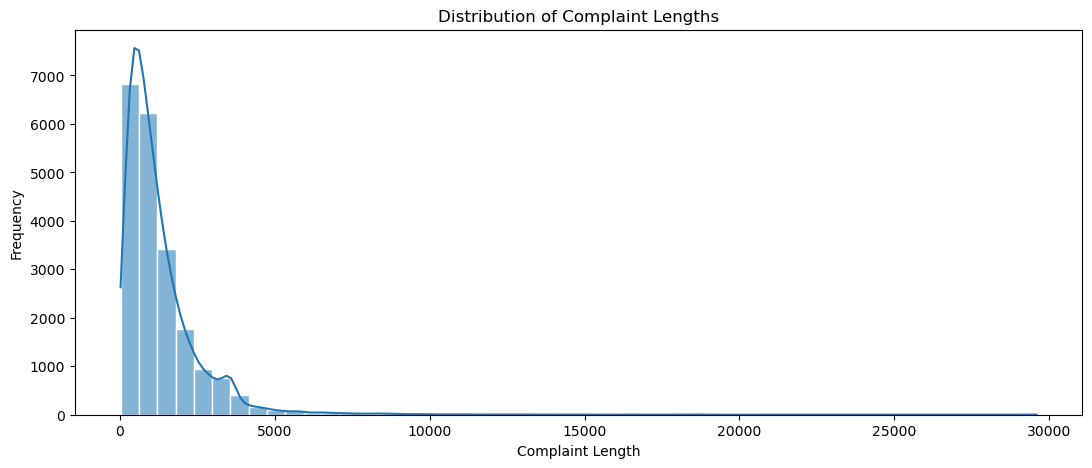

In [40]:
# Write your code here to visualise the data according to the 'Complaint' character length

# Create a new column 'complaint_length' that contains the length of each complaint
complaint_length = df_clean['complaints_lemmatized'].apply(len)

# Set the figure size
plt.figure(figsize=(13, 5))

# Plot a histogram of the complaint lengths
sns.histplot(complaint_length, edgecolor='white', bins=50, alpha=0.55, kde=True)
plt.xlabel('Complaint Length')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Lengths')
plt.show()

Distribution of complaint lengths is strongly right-skewed, indicating that most complaints are short, but there are a few very long ones that extend the range significantly.

#### Find the top 40 words by frequency among all the articles after processing the text.

In [41]:
# Get the list of English stop words
stop_words = nlp.Defaults.stop_words

# Create a new column with stop words removed
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
# Replace NaN values with an empty string
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')

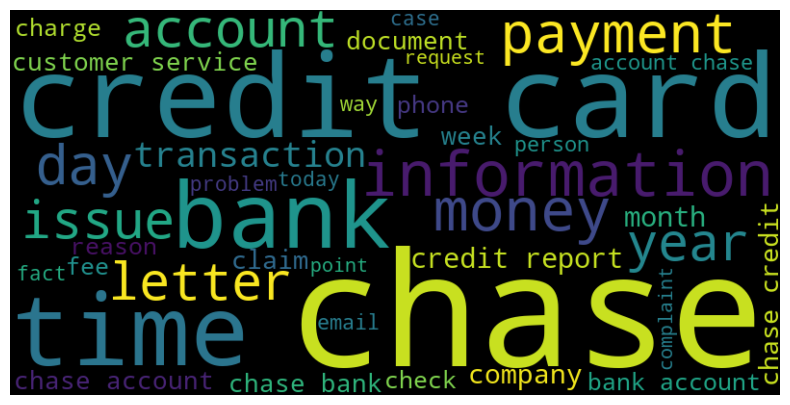

In [43]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud
# Combine all the complaints into a single string
all_complaints = ' '.join(df_clean['complaint_POS_removed'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=40).generate(all_complaints)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [4]:
#Removing -PRON- from the text corpus
# df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
if os.path.isfile('df_clean_v2.csv'):
  #tag remote collab
  df = pd.read_csv('df.csv')
  # load df_clean
  df_clean = pd.read_csv('df_clean_v2.csv')
  # Replace NaN values with an empty string
  df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')
  df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
else:
  #tag remote collab
  df = pd.read_csv('df.csv')
  # load df_clean    
  df_clean = pd.read_csv('df_clean_v1.csv')
  # Replace NaN values with an empty string
  df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
  
  # Define a function to replace a token
  def remove_PRON(sent):
    spacy.prefer_gpu()
    doc = nlp(sent)
    return ' '.join([token.text for token in doc if token.pos_ !='PRON'])

  # Apply the function to the 'complaint_POS_removed' column
  df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].apply(remove_PRON)
  # Replace NaN values with an empty string
  df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')

  df_clean.to_csv('df_clean_v2.csv', index=False)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

- __Unigram__ means taking only one word at a time.
- __Bigram__ means taking two words at a time.
- __Trigram__ means taking three words at a time. 

Source: `https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/`

In [3]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned dataframe(df_clean). 
from nltk import ngrams, FreqDist

# Replace NaN values with an empty string
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')

# Join all the complaints into a single string
all_words = ' '.join(df_clean['Complaint_clean']).split()

unigram_freq = FreqDist(all_words)

# Create a DataFrame from the result of word_freq.most_common(30)
df_unigram_freq = pd.DataFrame(unigram_freq.most_common(30), columns=['Unigram', 'Frequency'])

display (df_unigram_freq)

,Unigram,Frequency
0,chase,52879
1,account,46849
2,credit,32795
3,card,29618
4,bank,28337
5,payment,21066
6,time,13957
7,day,12902
8,charge,12229
9,check,12128


In [4]:
#Print the top 10 words in the unigram frequency
display(df_unigram_freq.head(10))

,Unigram,Frequency
0,chase,52879
1,account,46849
2,credit,32795
3,card,29618
4,bank,28337
5,payment,21066
6,time,13957
7,day,12902
8,charge,12229
9,check,12128


In [5]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

# Generate bigrams
bigrams = ngrams(all_words, 2)

bigram_freq = FreqDist(bigrams)

# Create a DataFrame from the result of word_freq.most_common(30)
df_bigram_freq = pd.DataFrame(bigram_freq.most_common(30), columns=['Bigram', 'Frequency'])

display (df_bigram_freq)

,Bigram,Frequency
0,"(credit, card)",12806
1,"(credit, report)",3850
2,"(account, chase)",3294
3,"(chase, credit)",3288
4,"(chase, account)",3133
5,"(chase, bank)",3101
6,"(customer, service)",3079
7,"(bank, account)",2997
8,"(account, account)",2724
9,"(check, account)",2209


In [6]:
#Print the top 10 words in the bigram frequency
display(df_bigram_freq.head(10))

,Bigram,Frequency
0,"(credit, card)",12806
1,"(credit, report)",3850
2,"(account, chase)",3294
3,"(chase, credit)",3288
4,"(chase, account)",3133
5,"(chase, bank)",3101
6,"(customer, service)",3079
7,"(bank, account)",2997
8,"(account, account)",2724
9,"(check, account)",2209


In [7]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

# Generate trigrams
trigrams = ngrams(all_words, 3)

trigram_freq = FreqDist(trigrams)

# Create a DataFrame from the result of word_freq.most_common(30)
df_trigram_freq = pd.DataFrame(trigram_freq.most_common(30), columns=['Trigram', 'Frequency'])

display (df_trigram_freq)

,Trigram,Frequency
0,"(chase, credit, card)",2170
1,"(credit, card, account)",1049
2,"(credit, card, company)",1005
3,"(credit, card, chase)",763
4,"(credit, card, credit)",523
5,"(account, credit, card)",475
6,"(inquiry, credit, report)",463
7,"(card, credit, card)",420
8,"(bank, credit, card)",416
9,"(credit, card, bank)",389


In [8]:
#Print the top 10 words in the trigram frequency
display(df_trigram_freq.head(10))

,Trigram,Frequency
0,"(chase, credit, card)",2170
1,"(credit, card, account)",1049
2,"(credit, card, company)",1005
3,"(credit, card, chase)",763
4,"(credit, card, credit)",523
5,"(account, credit, card)",475
6,"(inquiry, credit, report)",463
7,"(card, credit, card)",420
8,"(bank, credit, card)",416
9,"(credit, card, bank)",389


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [8]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [9]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Fit the TfidfVectorizer to the complaints column in df_clean and transform it into a Document Term Matrix (dtm)
dtm = tfidf.fit_transform(df_clean['Complaint_clean']) 
# dtm now holds the Document Term Matrix, which is a numerical representation of the text data

In [10]:
dtm.shape # Each row represents a document, and each column represents a word in the vocabulary

(20897, 7406)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [11]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [12]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state =40) #write your code here

In [13]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_
len(tfidf.get_feature_names_out())

7406

In [14]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)], 
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,business,number,transaction,fee,customer,reason
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,debt,application,information,year,balance,letter
Topic 3,loan,mortgage,home,chase,modification,property,year,letter,rate,document,bank,foreclosure,house,sale,time
Topic 4,charge,card,chase,transaction,dispute,fraud,claim,merchant,purchase,fee,service,phone,email,time,day
Topic 5,payment,balance,fee,interest,month,statement,day,time,date,bill,auto,chase,year,account,rate


In [58]:
%%script echo 'skipped'
#Load your nmf_model with the n_components i.e 5
if os.path.isfile('df_topic_words.csv'):
    df = pd.read_csv('df.csv')
    # load df_clean
    df_clean = pd.read_csv('df_clean_v2.csv')
    # Replace NaN values with an empty string
    df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')
    df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
    
    # load df_topic_words
    df_topic_words = pd.read_csv('df_topic_words.csv')
else: 
    df = pd.read_csv('df.csv')
    # load df_clean
    df_clean = pd.read_csv('df_clean_v2.csv')
    # Replace NaN values with an empty string
    df_clean['Complaint_clean'] = df_clean['Complaint_clean'].fillna('')
    df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].fillna('')
    
    from tqdm import tqdm
    df_topic_words = pd.DataFrame(columns=['num_topics']+[f'Word {i + 1}' for i in range(15)]).astype(str)
    num_topics_list = range(5,20+1)
    for i in tqdm(num_topics_list):
        num_topics = i #write the value you want to test out

        #keep the random_state =40
        nmf_model = NMF(n_components=num_topics, random_state =40) #write your code here
        # Fit the NMF model to the document-term matrix (dtm) and transform it into a matrix of topic weights (W)
        W = nmf_model.fit_transform(dtm) # shape (20897, 5)
        # Get the topic weights for each topic
        # This is a matrix where each row represents a topic, and each column represents a word in the vocabulary
        H = nmf_model.components_ # shape (5, 7406)
        len(tfidf.get_feature_names_out())

        #Print the Top15 words for each of the topics

        # vocabulary list
        words = np.array(tfidf.get_feature_names_out()) # shape(7406,)
        topic_words = pd.DataFrame(np.zeros((num_topics, 16)), index=[f'Topic {i + 1}' for i in range(num_topics)], 
                            columns=['num_topics']+[f'Word {i + 1}' for i in range(15)]).astype(str)

        for i in range(num_topics):
            # Get the indices of the top 15 words for the current topic
            ix = H[i].argsort()[::-1][:15] # shape(15,)
            # Assign the top 15 words to the current topic in the topic_words DataFrame
            topic_words.iloc[i] = [str(num_topics)] + [str(word) for word in words[ix]]

        df_topic_words = pd.concat([df_topic_words, topic_words])
    display(df_topic_words.head())
    df_topic_words.to_csv('df_topic_words.csv', index=False)

skipped


In [59]:
%%script echo 'skipped'
# find num_topics that has both 'theft' and 'fraud'
words_to_filter = ['theft', 'fraud']  # list of words to filter by
df_topic_words_filtered = df_topic_words[df_topic_words.apply(lambda row: all(word in row.values for word in words_to_filter), axis=1)]


skipped


In [15]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
'''num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state =40) #write your code here'''

# Get the topic weights for each document
W = nmf_model.fit_transform(dtm)

# Get the topic with the highest weight for each document
best_topics = W.argmax(axis=1)

In [16]:
#Assign the best topic to each of the complaints in Topic Column
topic_labels = {0: 'Bank account services', 1: 'Credit card / Prepaid card', 2: 'Others', 3: 'Theft/Dispute reporting', 4: 'Mortgages/loans'}
# df_clean['Topic'] = pd.Series(best_topics).map(topic_labels) #write your code to assign topics to each rows.
df_clean.loc[:,'Topic'] = pd.Series(best_topics) #write your code to assign topics to each rows.

In [17]:
df_clean.head()

,complaints,complaints_lemmatized,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning stop bank cardmember service debt veri...,morning stop bank cardmember service debt veri...,0
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,I upgrade my xxxx xxxx card in xxxx2018 and be...,I card 2018 agent upgrade date agent informati...,card 2018 agent upgrade date agent information...,1
2,chase card was reported on xxxx2019 however fr...,chase card be report on xxxx2019 however fraud...,card 2019 application identity consent service...,card 2019 application identity consent service...,1
3,on xxxx2018 while trying to book a xxxx xxxx t...,on xxxx2018 while try to book a xxxx xxxx tick...,2018 book ticket I offer ticket reward card I ...,2018 book ticket offer ticket reward card info...,1
4,my grand son give me check for 160000 i deposi...,my grand son give I check for 160000 I deposit...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [18]:
#Create the dictionary of Topic names and Topics

Topic_names = {0: 'Bank account services', 1: 'Credit card / Prepaid card', 2: 'Mortgages/loans', 3: 'Theft/Dispute reporting', 4: 'Others'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [19]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = training_data = pd.DataFrame()
training_data["complaint_what_happened"]= df_clean["complaints"]
training_data["Topic"] = df_clean["Topic"]

In [16]:
training_data

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,Bank account services
1,i upgraded my xxxx xxxx card in xxxx2018 and w...,Credit card / Prepaid card
2,chase card was reported on xxxx2019 however fr...,Credit card / Prepaid card
3,on xxxx2018 while trying to book a xxxx xxxx t...,Credit card / Prepaid card
4,my grand son give me check for 160000 i deposi...,Bank account services
...,...,...
20892,after being a chase card customer for well ove...,Credit card / Prepaid card
20893,on wednesday xxxxxxxx i called chas my xxxx xx...,Theft/Dispute reporting
20894,i am not familiar with xxxx pay and did not un...,Theft/Dispute reporting
20895,i have had flawless credit for 30 yrs ive had ...,Others


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [21]:
# Label encoding for topics
label_encoder = LabelEncoder()
training_data['topic_num'] = label_encoder.fit_transform(training_data['Topic'])

#Write your code to get the Vector count
# Count Vectorizer to get the word counts
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
# Transform the word counts to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [22]:
# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data['topic_num'], test_size=0.2, random_state=42)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [23]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Initialize models
log_reg = LogisticRegression(max_iter=1000)
decision_tree = DecisionTreeClassifier()
# random_forest = RandomForestClassifier(n_estimators=100)
naive_bayes = MultinomialNB()

In [24]:
# Train and evaluate Logistic Regression
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg, target_names=label_encoder.classes_))


Logistic Regression
Accuracy: 0.9282296650717703
Classification Report:
                             precision    recall  f1-score   support

     Bank account services       0.93      0.94      0.93      1027
Credit card / Prepaid card       0.92      0.95      0.93       977
           Mortgages/loans       0.95      0.94      0.95       702
                    Others       0.96      0.87      0.91       475
   Theft/Dispute reporting       0.91      0.91      0.91       999

                  accuracy                           0.93      4180
                 macro avg       0.93      0.92      0.93      4180
              weighted avg       0.93      0.93      0.93      4180



In [19]:
# Train and evaluate Decision Tree
decision_tree.fit(X_train, y_train)
y_pred_decision_tree = decision_tree.predict(X_test)
print("\nDecision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_decision_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_decision_tree, target_names=label_encoder.classes_))


Decision Tree
Accuracy: 0.7985645933014354
Classification Report:
                             precision    recall  f1-score   support

     Bank account services       0.83      0.81      0.82      1027
Credit card / Prepaid card       0.82      0.83      0.82       977
           Mortgages/loans       0.82      0.85      0.84       702
                    Others       0.73      0.72      0.72       475
   Theft/Dispute reporting       0.77      0.76      0.76       999

                  accuracy                           0.80      4180
                 macro avg       0.79      0.79      0.79      4180
              weighted avg       0.80      0.80      0.80      4180



In [20]:
random_forest = RandomForestClassifier(max_depth=10)
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_test)
print("\nRandom Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_random_forest))
print(classification_report(y_pred=y_pred_random_forest, y_true=y_test))


Random Forest
Accuracy: 0.707177033492823
              precision    recall  f1-score   support

           0       0.70      0.84      0.77      1027
           1       0.59      0.87      0.70       977
           2       0.86      0.72      0.78       702
           3       1.00      0.03      0.06       475
           4       0.79      0.73      0.76       999

    accuracy                           0.71      4180
   macro avg       0.79      0.64      0.61      4180
weighted avg       0.76      0.71      0.67      4180



In [21]:
# Train and evaluate Naive Bayes
naive_bayes.fit(X_train, y_train)
y_pred_naive_bayes = naive_bayes.predict(X_test)
print("\nNaive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_naive_bayes))
print(classification_report(y_pred=y_pred_naive_bayes, y_true=y_test))



Naive Bayes
Accuracy: 0.7284688995215312
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      1027
           1       0.66      0.80      0.72       977
           2       0.86      0.74      0.80       702
           3       1.00      0.02      0.04       475
           4       0.74      0.81      0.78       999

    accuracy                           0.73      4180
   macro avg       0.80      0.65      0.63      4180
weighted avg       0.77      0.73      0.69      4180



In [22]:
results = {
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "Naive Bayes"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log_reg),
        accuracy_score(y_test, y_pred_decision_tree),
        accuracy_score(y_test, y_pred_random_forest),
        accuracy_score(y_test, y_pred_naive_bayes)]
}

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy
0,Logistic Regression,0.928230
1,Decision Tree,0.798565
2,Random Forest,0.707177
3,Naive Bayes,0.728469


#### Conclusion:



Among the three models evaluated (__Logistic Regression__, __Decision Tree__, __Random Forest__), __Logistic Regression__ performed the best in terms of accuracy.
With an accuracy of approximately `0.93`, __Logistic Regression__ demonstrates its effectiveness in classifying complaints into predefined topics.

__Logistic Regression__ emerged as the top-performing model in terms of accuracy, there's potential for optimization and refinement in Decision Tree and Random Forest models to enhance their effectiveness in topic classification of complaints.

#### Model Inference

In [38]:
import random

# Select 10 random texts from training_data['complaint_what_happened']
random_texts = random.sample(list(training_data['complaint_what_happened']), 10)

# Convert the random texts to TF-IDF vectors
random_texts_tfidf = tfidf_transformer.transform(count_vect.transform(random_texts))

# Use the logistic regression model to predict the topics
predicted_topics = log_reg.predict(random_texts_tfidf)

# Print the predicted topics
for i, text in enumerate(random_texts):
    print(f"Text: {text}")
    print(f"Predicted Topic: {label_encoder.inverse_transform([predicted_topics[i]])[0]}")
    print()

Text: reference xxxx complaint against chase bank credit card services
my complain is against the xxxx procedures all your announcements indicate you are totally dedicated to support and protect the public in my case number listed above that was not the case and proved that the bcfp was in league with the chase bank against me
i made a complaint against chase bank details are provided in my complaint my complaint was passed to the chase bank who responded i was sent the response and made a rebutall that had significant information to contradict the bank statement in the meantime the xxxx stated the case was closed and my rebutall could not be forwarded to the chase bank that is not in the interest of the public complaintant but protects the chase bank this process needs to be changed i also ask for a review of how my case was handled by bcfp staff my rebutall needs to be sent to chase bank basically deducted 7900 per year since xxxx2004 for a total of about 100000 without my aithoroty 